# Hidden Markov Models

A hidden Markov model (HMM) consists of a discrete-time, discrete-state Markov chain, with hidden states $z_t \in \{1,...,K \}$, where time $t=1,...,T$, as well as an observation model $p(\boldsymbol{x}_t| z_t)$, where $\boldsymbol{x}_t$ can be discrete or continuous. 

There are various inference problems in HMMs, including:

- Filtering, where we compute $p(z_t|\boldsymbol{x}_{1:t})$  
- Smoothing, where we compute $p(z_t|\boldsymbol{x}_{1:T})$
- Fixed lag smoothing, $p(z_{t-l}|\boldsymbol{x}_{1:t})$
- Prediction, $p(z_{t+h}|\boldsymbol{x}_{1:t})$
- Maximum a posteriori prediction, $\mathrm{arg max}_{\boldsymbol{z}_{1:T}} p(\boldsymbol{z}_{1:T}|\boldsymbol{x}_{1:T})$
- Posterior samples, $\boldsymbol{z}_{1:T} \sim p(\boldsymbol{z_{1:T}}|\boldsymbol{x}_{1:T})$
- Probability of the evidence, $p(\boldsymbol{x}_{1:T})$

Based on Ch17 of Murphy's Machine Learning: A Probabilistic Perspective

Author: Juvid Aryaman

In [1]:
import mystyle.sty as sty # see https://github.com/jaryaman/mystyle
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
sty.reset_plots()
sty.update_functions_on_fly()
sty.ignore_warnings_all()

## Occasionally dishonest casino

For an example of an HMM, let's consider the occasionally dishonest casino. In this case, $x_t \in {1,2,...,6}$ represents the roll of a die, and $z_t$ represents the identity of the die being used. If the die is currently fair, on the next roll there is a 5% chance the casino swaps the die for a loaded die. If the die is currently unfair, on the next roll there is a 10% chance the casino swaps the die back to the fair die. The unfair die rolls a 6 with 50% probability, with all other faces having equal probability. 

![](./Figures/ODC.png)

The state of the die is hidden from us, we only know the die roll values. Whilst playing in the casino, we may wish to e.g. predict the chance that the die is fair given all the rolls up to now. This would be an example of filtering.

### Make synthetic data

We can model the number of consecutive rolls with the current die using a negative binomial distribution. 

The negative binomial distribution describes a sequence of ($k$) i.i.d. Bernoulli trials, repeated until a predefined, non-random number of successes ($n$) occurs and $p$ is the probability of a single success

$$f(k) = \binom{k+n-1}{n-1} p^n (1-p)^k$$

So let success = leaving the state we're currently in. This is either 0.05 (fair die) or 0.1 (unfair die).

In [3]:
def bit_vector_to_die_value(x):
    return np.argmax(x) + 1

In [4]:
np.random.seed(12345)
fair_probs = np.ones(6)/6
unfair_probs = np.hstack((np.ones(5)/10,0.5))

nswaps = 11

die_outcomes = np.array([])

n_rolls_fair_arr = []
n_rolls_unfair_arr = []

# Inititalise in fair state
for i in range(nswaps):
    # When we land in the state, we roll first, then decide to transition. Hence add 1.
    n_rolls_fair = ss.nbinom.rvs(1,0.05) + 1 
    n_rolls_fair_arr.append(n_rolls_fair)
    bits_fair = ss.multinomial.rvs(n=1, p=fair_probs, size=n_rolls_fair)
    die_vals_fair = np.apply_along_axis(bit_vector_to_die_value,1,bits_fair)
    die_outcomes = np.append(die_outcomes,die_vals_fair)
    
    n_rolls_unfair = ss.nbinom.rvs(1,0.1) + 1
    n_rolls_unfair_arr.append(n_rolls_unfair)
    bits_unfair = ss.multinomial.rvs(n=1, p= unfair_probs, size=n_rolls_unfair)
    die_vals_unfair = np.apply_along_axis(bit_vector_to_die_value,1,bits_unfair)
    die_outcomes = np.append(die_outcomes,die_vals_unfair)
die_outcomes = die_outcomes.astype(int)    

## Forward algorithm

We wish to compute the (filtered) **belief state** $p(z_t|\boldsymbol{x}_{1:t})$ through repeated application of Bayes rule. Let's suppose we know the following quantities about the system:

- Transition matrix $\Psi(i,j) = p(z_t=j|z_{t-1}=i)$
- Local evidence vectors: $\psi_t(j) = p(x_t|z_t=j)$ 
- Initial belief of the state distribution: $\pi(j) = p(z_1=j)$ 

Now, Bayes rule states

$$P(B|A) = \frac{P(A|B) P(B)}{P(A)}.$$

Then,

$$p(z_t=j|\boldsymbol{x}_{1:t}) = p(z_t=j|x_t, \boldsymbol{x}_{1:t-1}) = \frac{p(x_t|z_t=j, \boldsymbol{x}_{1:t-1}) p(z_t=j|\boldsymbol{x}_{1:t-1})}{p(x_t|\boldsymbol{x}_{1:t-1})}.$$

But from conditional independence of the HMM, $p(x_t|z_t=j, \boldsymbol{x}_{1:t-1}) = p(x_t|z_t=j) = \psi_t(j)$. 

Let's define $Z_t$ and $\alpha_t(j)$ as

$$Z_t = p(x_t|\boldsymbol{x}_{1:t-1}) = \sum_j p(x_t|z_t=j)p(z_t=j|\boldsymbol{x}_{1:t-1})$$

$$\alpha_t(j)=p(z_t=j|\boldsymbol{x}_{1:t})=p(x_t|z_t=j) p(z_t=j|\boldsymbol{x}_{1:t-1})/Z_t.$$ 

Then,

$$ p(z_t=j|\boldsymbol{x}_{1:t-1}) = \sum_i p(z_t=j|z_{t-1}=i) p(z_{t-1}=i|\boldsymbol{x}_{1:t-1}) = \sum_i \Psi(i,j) \alpha_{t-1}(i).$$

Therefore, we arrive at the **update rule** for the forward algorithm:

$$\boldsymbol{\alpha}_t \propto \boldsymbol{\psi}_t \odot \boldsymbol{\Psi}^T \boldsymbol{\alpha}_{t-1}$$

where $\odot$ denotes an element-wise product (Hadamard product). Hence we may compute $\boldsymbol{\alpha}_t$ at every time step by normalising $\boldsymbol{\psi}_t \odot \boldsymbol{\Psi}^T \boldsymbol{\alpha}_{t-1}$. 

In [5]:
transition_matrix_trans = np.array([[0.95, 0.05], [0.1, 0.9]]).T
local_evidence = np.vstack((fair_probs,unfair_probs)).T

# Initial prior as the steady-state distribution of the Markov chain
w, v = np.linalg.eig(transition_matrix_trans)
ev = v[:,np.argmax(w==1)]
initial_state_distn = ev/ev.sum()

In [6]:
t_final = len(die_outcomes)

In [7]:
alpha_t = local_evidence[die_outcomes[0]-1,:] * np.dot(transition_matrix_trans, initial_state_distn)
Z_t = np.sum(alpha_t)
alpha_t = alpha_t/Z_t
alpha_t

array([0.76923077, 0.23076923])

In [8]:
alpha_t_all = np.zeros((t_final,2))
alpha_t_all[0,:] = alpha_t

Z_t_all = np.zeros(t_final)
Z_t_all[0] = Z_t

In [9]:
for i in range(1,t_final):
    alpha_t_old = alpha_t_all[i-1,:]
    
    alpha_t = local_evidence[die_outcomes[i]-1,:] * np.dot(transition_matrix_trans, alpha_t_old)
    Z_t = np.sum(alpha_t)
    alpha_t = alpha_t/Z_t
    
    alpha_t_all[i,:] = alpha_t
    Z_t_all[i] = Z_t

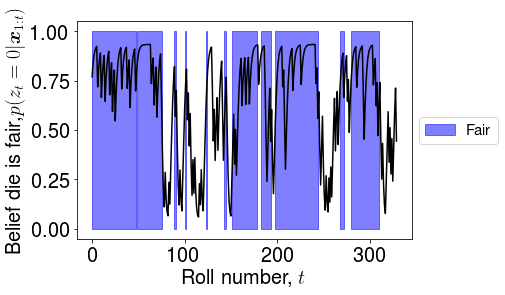

In [10]:
fig, ax = plt.subplots()
ax.plot(np.arange(t_final),alpha_t_all[:,0],'-k')

left=0
for i, nrolls in enumerate(n_rolls_fair_arr):
    if i == 0:
        ax.fill_between([left, left+nrolls],[0,0],[1,1],color='blue',
                    alpha=0.5, label='Fair')
    else:
        ax.fill_between([left, left+nrolls],[0,0],[1,1],color='blue',
                    alpha=0.5)
    left = left + nrolls + n_rolls_unfair_arr[i]
sty.legend_outside(ax)
sty.remove_tex_axis(ax, ytick_fmt="%.2f")
    
ax.set_xlabel('Roll number, $t$')
ax.set_ylabel(r'Belief die is fair,$p(z_t=0|\boldsymbol{x}_{1:t})$');

Blue shaded regions denote samples that were generated using a fair die. The black line is our belief that the die is fair.